In [2]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), ".."))

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import v2

from tqdm import tqdm

from satellite2map.datasets import Maps
from satellite2map.models.generator import UnetGenerator
from satellite2map.metricas import *
import satellite2map.transforms as T

from dataclasses import dataclass
import time

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pix2Pix evaluation

In [3]:
@dataclass
class hyperparameters:
    # training hyperparams
    n_epochs: int = 100
    batch_size: int = 32
    lr: float = 2e-3

hyperparams = hyperparameters()

## Loading data

In [4]:
transforms = T.Compose([T.Resize((256,256)),
                        T.ToTensor(),
                        T.Normalize(mean=[0.5, 0.5, 0.5],
                                     std=[0.5, 0.5, 0.5])])

train_dataset = Maps(root='../data/raw', mode='train', transform=transforms, download=False)
val_dataset   = Maps(root='../data/raw', mode='val', transform=transforms, download=False)

train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=True)
val_dataloader   = DataLoader(val_dataset,   batch_size=hyperparams.batch_size, shuffle=True)

1 torch.Size([3, 256, 256]) torch.Size([3, 256, 256])
2 torch.Size([3, 256, 256]) torch.Size([3, 256, 256])
3 torch.Size([3, 256, 256]) torch.Size([3, 256, 256])
4 torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


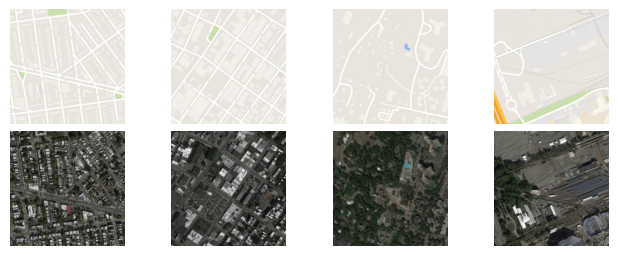

In [5]:
import matplotlib.pyplot as plt
import numpy as np

for i, (sat, map) in enumerate(train_dataset):
    i = i + 1
    print(i, sat.shape, map.shape)

    ax = plt.subplot(1, 4, i)
    plt.tight_layout()
    #ax.set_title('Satellite #{}'.format(i))
    ax.axis('off')
    sat = sat * 0.5 + 0.5
    plt.imshow(sat.permute((1, 2, 0)).numpy())

    ax = plt.subplot(2, 4, i)
    plt.tight_layout()
    #ax.set_title('Map #{}'.format(i))
    ax.axis('off')
    map = map * 0.5 + 0.5
    plt.imshow(map.permute((1, 2, 0)).numpy())

    if i == 4:
        plt.show()
        break

# Loading model

In [6]:
generator = UnetGenerator().to(DEVICE)
gen_state_dict = torch.load('../models/pix2pix/checkpoints/checkpoint_100.pth')['gen_weights']
generator.load_state_dict(gen_state_dict)

/tmp/ipykernel_52860/2862193365.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_state_dict = torch.load('../models/pix2pix/checkpoints/checkpoint_100.pth')['gen_weig

<All keys matched successfully>

# Visualizing results

maps: 1.0, 0.6235294342041016
gen maps: 1.0, -0.7181870341300964
maps: 1.0, 0.2627451419830322
gen maps: 1.0, -0.8999941945075989
maps: 1.0, 0.2549020051956177
gen maps: 1.0, -0.9062261581420898
maps: 1.0, 0.2549020051956177
gen maps: 1.0, -0.8498408794403076


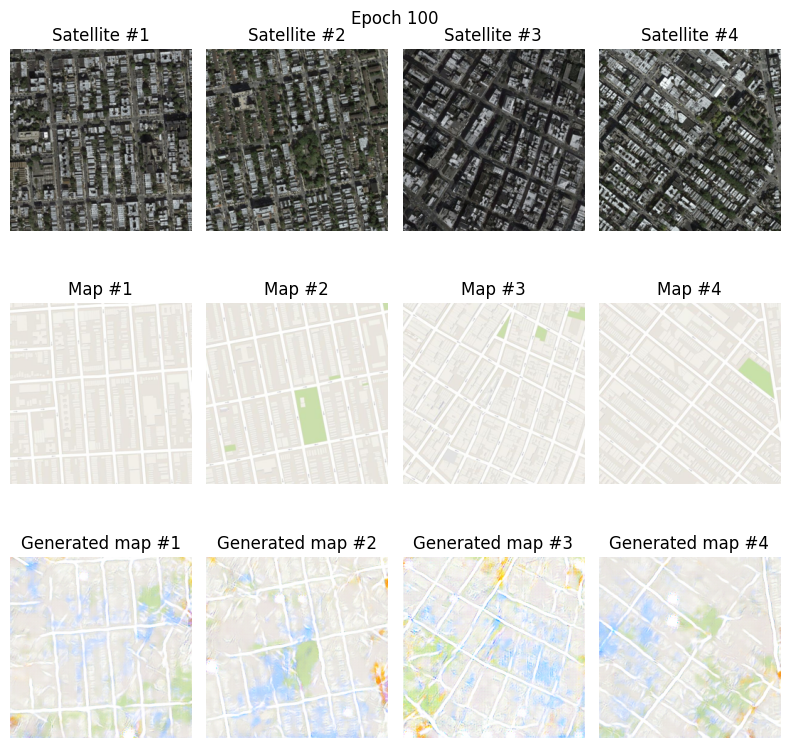

In [7]:
# fig = plt.figure(figsize=(8, 8))
# indexes = torch.randint(0, len(val_dataset), (4,))
# for i in range(4):
#     (sat, map) = val_dataset[indexes[i]]
#     i = i + 1
#     # print(i, sat.shape, map.shape)
#     gen_map = generator(sat.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()

#     # Sattelite (input)
#     ax = fig.add_subplot(3, 4, i)
#     ax.set_title('Satellite #{}'.format(i))
#     ax.axis('off')
#     sat = sat * 0.5 + 0.5
#     plt.imshow(sat.permute((1, 2, 0)).numpy())

#     # Map (target)
#     ax = fig.add_subplot(3, 4, i+4)
#     ax.set_title('Map #{}'.format(i))
#     ax.axis('off')
#     print(f'maps: {map.max()}, {map.min()}')
#     map = map * 0.5 + 0.5
#     plt.imshow(map.permute((1, 2, 0)).numpy())

#     # Generated map (output)
#     ax = fig.add_subplot(3, 4, i+8)
#     ax.set_title('Generated map #{}'.format(i))
#     ax.axis('off')
#     print(f'gen maps: {gen_map.max()}, {gen_map.min()}')
#     gen_map = gen_map * 0.5 + 0.5
#     plt.imshow(gen_map.permute((1, 2, 0)).cpu().detach().numpy())
#     if i == 4:
#         fig.tight_layout()
#         fig.suptitle('Epoch 100')
#         plt.show()
#         break

# Calculating metrics

In [10]:
# sampling a random batch from validation dataset
sat_batch, map_batch = next(iter(val_dataloader))
sat_batch, map_batch = sat_batch.to(DEVICE), map_batch.to(DEVICE)

# generating maps
gen_map_batch = generator(sat_batch)

# calculating metrics
mse = MSE(gen_map_batch, map_batch)
psnr = PSNR(gen_map_batch, map_batch)
ssim = SSIM(gen_map_batch, map_batch)
pa = PA(gen_map_batch, map_batch)
print(f'MSE: {mse}, PSNR: {psnr}, SSIM: {ssim}, PA: {pa}')

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.